# import packages

In [13]:
from importlib import reload
import src.PATH
reload(src.PATH)

<module 'src.PATH' from '/home/wergillius/Project/pan-cancer-leukocyte/leukocyte/src/PATH.py'>

In [14]:
import os,sys
from src.PATH import *

In [15]:
from src import utils
from src import leukocyte_cluster as LEUC
from src import my_metrics

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [18]:
import numpy as np
import pandas as pd

In [19]:
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.core.pylabtools import figsize
from matplotlib.backends.backend_pdf import PdfPages

# read data

In [20]:
DF = utils.read_leukocyte(leukocyte_path,False) 

DF.shape

(3149, 23)

In [21]:
local_DF,statistics = LEUC.statistics_preprocess(DF,False)
local_DF.shape

(3136, 21)

In [22]:
statistics

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
count,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,...,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000
mean,0.024623,0.005764,0.059805,0.121343,0.000257,0.132002,0.029839,0.028961,0.036026,0.009331,...,0.013202,0.169362,0.082673,0.142114,0.031134,0.015232,0.038540,0.011322,0.001536,0.008407
std,0.034925,0.026111,0.071388,0.108665,0.005433,0.085059,0.040141,0.027538,0.033870,0.022585,...,0.028296,0.143603,0.051582,0.088141,0.047246,0.032901,0.038034,0.032586,0.006614,0.022469
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001459,0.000000,0.006892,0.041314,0.000000,0.068893,0.000000,0.003569,0.008669,0.000000,...,0.000000,0.058648,0.044816,0.083319,0.000977,0.000000,0.008792,0.000000,0.000000,0.000000
50%,0.013046,0.000000,0.035734,0.091548,0.000000,0.129400,0.012457,0.024596,0.027958,0.000000,...,0.000383,0.133455,0.078908,0.123914,0.013668,0.000000,0.032765,0.000000,0.000000,0.000492
75%,0.034194,0.000000,0.087824,0.170791,0.000000,0.189928,0.047390,0.045391,0.055075,0.004960,...,0.013049,0.250835,0.113125,0.177284,0.039623,0.017391,0.056499,0.000000,0.000000,0.007676
95%,0.086601,0.031509,0.199627,0.346360,0.000000,0.276856,0.114767,0.080480,0.103803,0.055282,...,0.066343,0.450996,0.179019,0.313845,0.121521,0.078963,0.101598,0.077124,0.010728,0.038090
99%,0.167429,0.129331,0.336627,0.489507,0.000000,0.352423,0.168835,0.115207,0.140001,0.113156,...,0.133884,0.597236,0.225834,0.460136,0.221906,0.152542,0.171221,0.158059,0.031804,0.107757
max,0.369883,0.569483,0.528587,0.636114,0.258062,0.484746,0.319272,0.225572,0.245822,0.222941,...,0.359823,0.904766,0.331703,0.683108,0.534779,0.494217,0.423361,0.370647,0.119938,0.457435


In [17]:
[col for col in DF.columns if col not in local_DF.columns]

['T cells CD4 naive', 'Eosinophils']

In [43]:
local_DF.iloc[:,1:].columns

Index(['B cells naive', 'B cells memory', 'Plasma cells', 'T cells CD8',
       'T cells CD4 memory resting', 'T cells CD4 memory activated',
       'T cells follicular helper', 'T cells regulatory (Tregs)',
       'T cells gamma delta', 'NK cells resting', 'NK cells activated',
       'Monocytes', 'Macrophages M0', 'Macrophages M1', 'Macrophages M2',
       'Dendritic cells resting', 'Dendritic cells activated',
       'Mast cells resting', 'Mast cells activated', 'Neutrophils'],
      dtype='object')

In [23]:
label_df = pd.read_csv(os.path.join(data_path,'label','cluster_labelALL1.csv'),index_col=0)
print(label_df.shape)
label_df.tail()

(3136, 3)


,id,ac,km
3144,TCGA-BH-A18T-01A-11R-A12D-07,1,3
3145,TCGA-E2-A1L7-01A-11R-A144-07,0,1
3146,TCGA-LL-A5YO-01A-21R-A28M-07,2,3
3147,TCGA-A7-A4SE-01A-11R-A266-07,1,0
3148,TCGA-A7-A0DA-01A-31R-A115-07,1,0


In [25]:
n_data,label,_ = LEUC.sort_data_by_label(local_DF.iloc[:,1:].values,labels=None,metrics=None,direct_label= label_df.km.values)

In [53]:
n_data = np.divide(n_data,n_data.sum(axis=1).reshape(-1,1))

preprocess of data

In [27]:
cell_color = utils.read_color()

In [46]:
color_ls = cell_color.loc[local_DF.iloc[:,1:].columns,:].values

In [42]:
len(local_DF.columns)

21

In [30]:
my_cancer_type=['TNBC','NSCLC','HNSCC','CERVICAL','STOMACH','KIDNEY','BLADDER','MELANOMA','COLON','LIVER']

formal_name=['TNBC','NSCLC','HNSC','CESC','STAD','KIC','BLAC','SKCM','COREAD','LIHC']

name=pd.DataFrame(dict(zip(['my_cancer_type','formal_name'],[my_cancer_type,formal_name])))

In [31]:
name.my_cancer_type

0        TNBC
1       NSCLC
2       HNSCC
3    CERVICAL
4     STOMACH
5      KIDNEY
6     BLADDER
7    MELANOMA
8       COLON
9       LIVER
Name: my_cancer_type, dtype: object

### cluster ni all

In [33]:
os.path.exists(os.path.join(tsne_path,'ALL_tsne_p30.csv'))

True

/home/shuying/Documents/ZwZ/pan-cancer-leukocyte/leukocyte/src/leukocyte_cluster.py:65: RuntimeWarning: invalid value encountered in greater
  row_screen = (np.sum(v_data > threshold1,axis=1) <4) | (np.sum(v_data > threshold2,axis=1) <2)


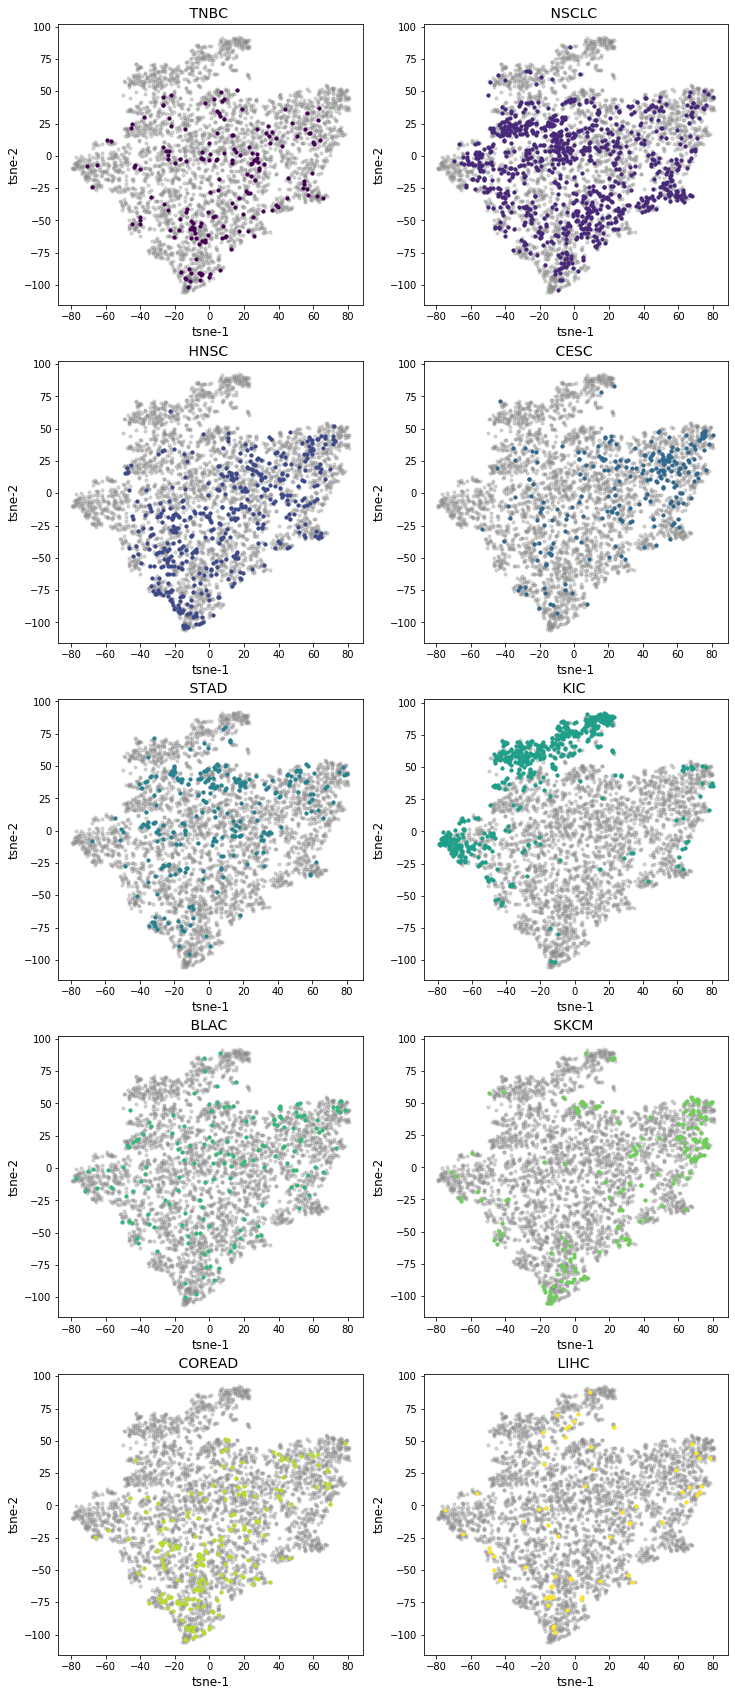

In [15]:
fig = plt.figure(figsize=(12,30))
i = 0
for cancer_type in name.my_cancer_type:
    ax = fig.add_subplot(5,2,i+1)
    local_DF,statistics = LEUC.statistics_preprocess(DF[cancer_type],False)
    LEUC.cluter_in_all_no_label(local_DF,cancer_type,ax=ax,**{'color':cm.viridis(i/9)})
    ax.set_title(' {}  '.format(name.formal_name.values[i]),fontsize=14)
    i += 1

this workes !    
save to pdf  

In [16]:
pdf = PdfPages('caner_type_distribution.pdf')
pdf.savefig(fig)
pdf.close()

### legend of stack barplot

In [12]:
local_DF,_ = LEUC.statistics_preprocess(DF,False)
# all_data =local_DF.iloc[:,1:].values
# ALL1 = pd.read_csv(os.path.join(data_path,'label','cluster_labelALL1.csv'),index_col=0)

    
    
old4 = ['A6_Stage','A3_T','A4_N','A5_M']
new4 = ['A18_Sex','race_list.race','age_at_initial_pathologic_diagnosis','number_pack_years_smoked']
stage=pd.read_csv(
    os.path.join(data_path,'label','patient_stage.csv'),
    index_col=0
    ).loc[:,new4]

In [12]:
# following old method
# labels,metrics = leukocyte_cluster.cluster3(all_data)
# all_data,label = leukocyte_cluster.sort_data_by_label(all_data,labels,metrics)

this will take several minutes


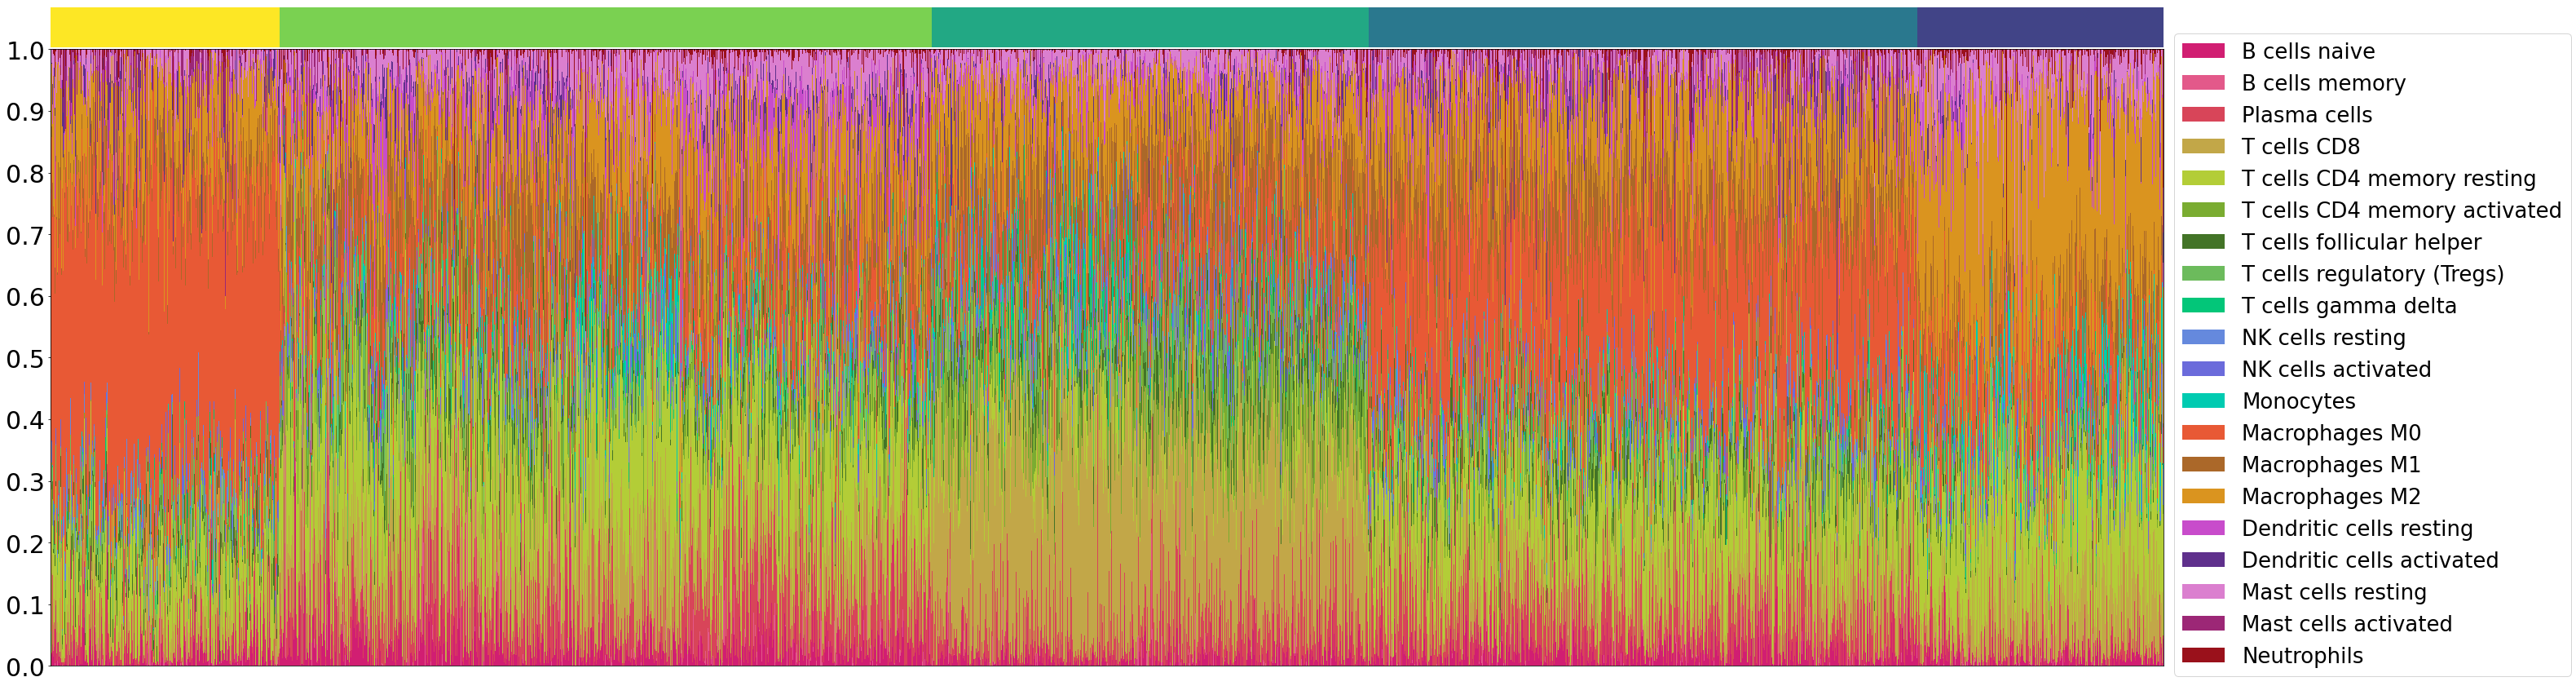

In [75]:
reload(LEUC)

stackbar = PdfPages("report/20210309_stackbar.pdf")
LEUC.stack_barplot(n_data,label,cell_label=local_DF.iloc[:,1:].columns,cmap=color_ls)
stackbar.savefig()
stackbar.close()

## heat map

In [34]:
from sklearn.preprocessing import normalize

In [27]:
n_data.shape

(3136, 20)

In [28]:
def Z_norma(data,log=False):
    assert data.shape[1] == 20
    if log:
        data = np.log(data+1e-10)
    Ranges = np.max(data,axis=0)-  np.min(data,axis=0)
    miu = np.min(data,axis=0)
    
    return data-miu / Ranges

In [29]:
Z_data = normalize(n_data.T,axis=1)

In [30]:
np.sum(Z_data,axis=1)

array([32.42244538, 11.98215996, 36.00542584, 41.75089077, 47.11034834,
       33.41990497, 40.61400447, 40.88357738, 21.39900132, 26.73747357,
       36.86452395, 23.85640607, 42.75132743, 47.57258275, 47.63209994,
       30.87611448, 23.54693388, 39.9168415 , 18.33411853, 19.66578329])

In [31]:
cm.YlGn

In [32]:
labels = label
z_norm_data = Z_norma(n_data,False)

In [43]:
colors = utils.read_color()         # read leukocyte color

cell_label=list(local_DF.columns)[1:]                                       # left cell
color_ls=colors.loc[cell_label].HEX.values   # select from all

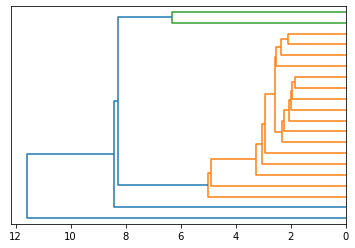

In [37]:
tree = dendrogram(Z,p=13,truncate_mode='level',no_labels=True,distance_sort=True,orientation='left')

In [53]:
es = cm.ScalarMappable(norm=None, cmap=cm.Spectral_r)

In [76]:
def stack_imshow(data,labels):

    fig = plt.figure(figsize=(50,15))
    
    ax = fig.add_axes([0.08,0.1,0.74,0.7])
    ax2 = fig.add_axes([0.08,0.8,0.74,0.05])
    ax3 = fig.add_axes([0,0.1,0.08,0.7])
    ax4 = fig.add_axes([0.85,0.1,0.1,0.7])
#     ax.axis('off')    

    ax2.axis('off')
    ax3.axis('off')
    ax3.yaxis.set_ticks(range(1,20));
    ax4.axis('off')
    
    im=ax.imshow(data.T,aspect='auto',cmap=cm.Spectral_r)
    
    ax.yaxis.set_ticks_position("right")
    ax.yaxis.set_ticks(range(20))
    ax.set_yticklabels(leuko_label,fontsize=25)
    
    label_num = np.bincount(labels)
    LEFT = 0
    iicolor = 0
    for num in label_num:
        ax2.barh(0,num,left=LEFT,color=cm.viridis_r(iicolor/len(label_num)))
        ax2.set_xlim(0,data.shape[0]-1)
        ax2.axis('off')
        LEFT += num
        iicolor += 1
        
    tree = dendrogram(Z,p=13,truncate_mode='level',no_labels=True,ax=ax3,distance_sort=True,orientation='left')

    fig.colorbar(im,ax=ax4)
    
    return fig

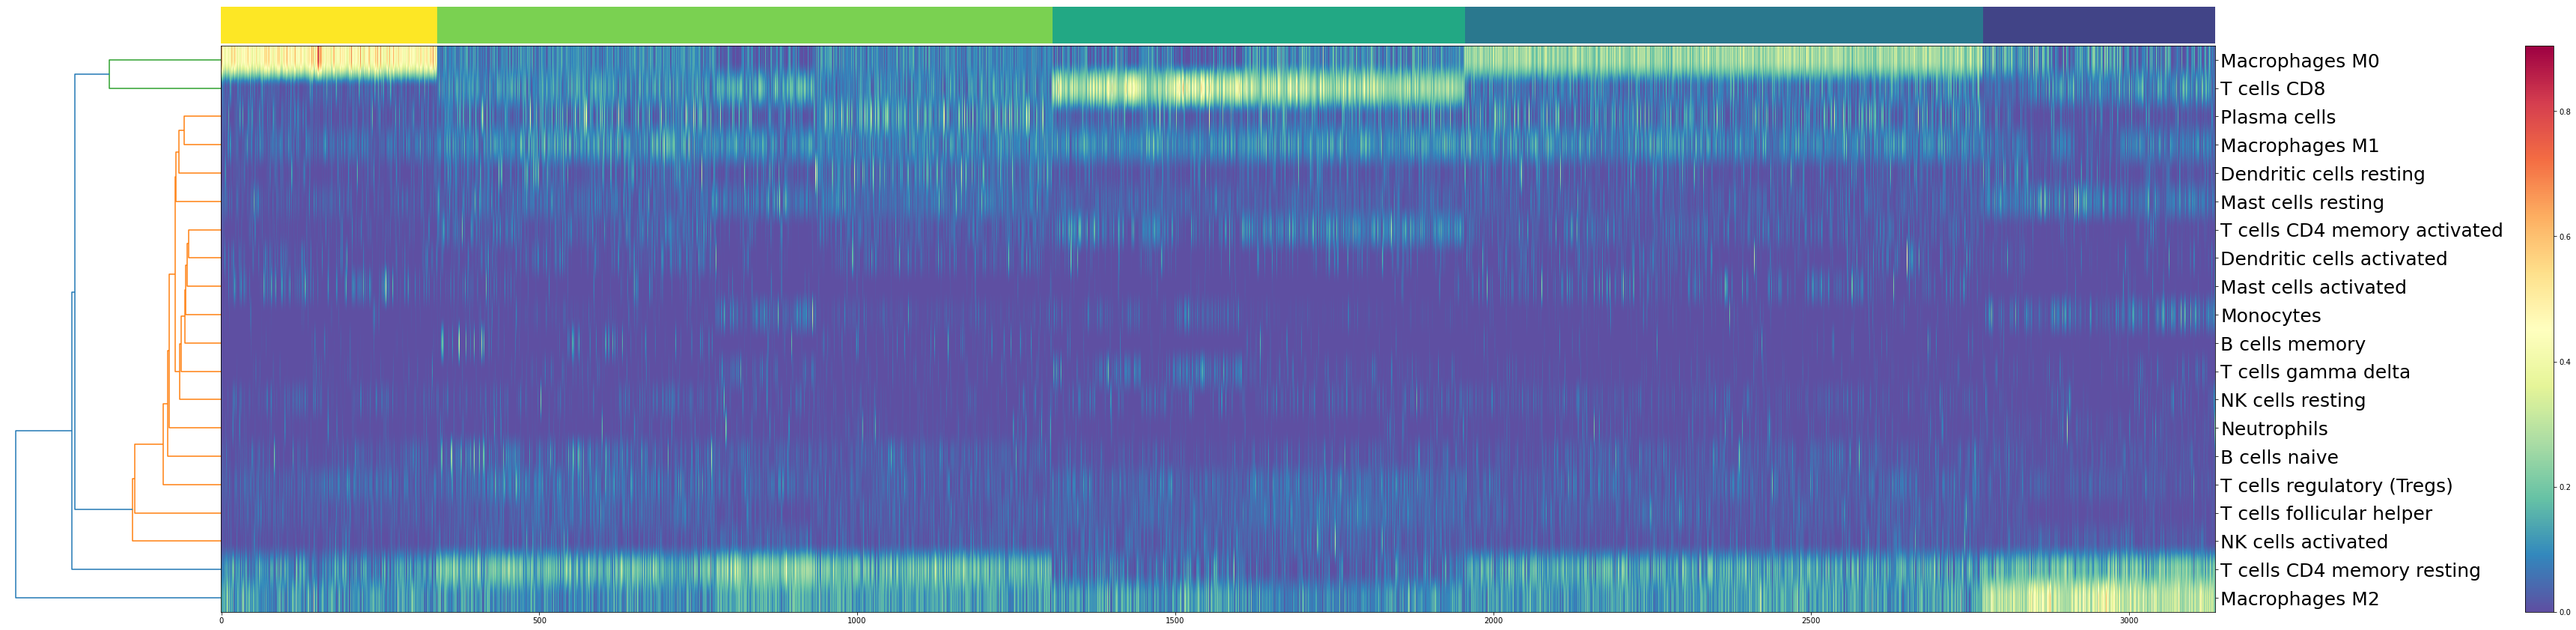

In [77]:
fig=stack_imshow(z_norm_data[:,tree["leaves"]],labels)

In [78]:
fig.savefig("stacked_heatmatp_1008_2.pdf",format='pdf')

## dendrogram tree

In [34]:
from scipy.cluster.hierarchy import linkage,dendrogram,distance 

In [35]:
def hierarchical_tree(data,metric='euclidean',p_start=5,p_step=1):
    disMat=distance.pdist(data,metric=metric)
    Z=linkage(disMat,method='average') 
    p = p_start
    fig = plt.figure(figsize=(16,12))
    axs = fig.subplots(3,3)
    for i in range(3):
        for j in range(3):
            ax = axs[i,j]
            tree = dendrogram(Z,p=p,truncate_mode='level',no_labels=True,distance_sort=True,ax=ax)
            ax.set_title('P = {}  N Clusters = {}'.format(p, len(tree['leaves'])))
            p += p_step
    return Z

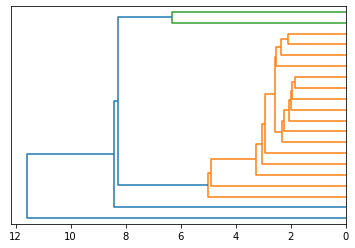

In [37]:
tree = dendrogram(Z,p=13,truncate_mode='level',no_labels=True,distance_sort=True,orientation='left')

In [38]:
tree.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

In [39]:
tree["leaves"]

[12, 3, 2, 13, 15, 17, 5, 16, 18, 11, 1, 8, 9, 19, 0, 7, 6, 10, 4, 14]

In [40]:
leuko_label = np.array(local_DF.columns[1:])[tree["leaves"]]

In [41]:
tree["icoord"]

[[125.0, 125.0, 135.0, 135.0],
 [115.0, 115.0, 130.0, 130.0],
 [105.0, 105.0, 122.5, 122.5],
 [95.0, 95.0, 113.75, 113.75],
 [85.0, 85.0, 104.375, 104.375],
 [75.0, 75.0, 94.6875, 94.6875],
 [165.0, 165.0, 175.0, 175.0],
 [155.0, 155.0, 170.0, 170.0],
 [145.0, 145.0, 162.5, 162.5],
 [84.84375, 84.84375, 153.75, 153.75],
 [65.0, 65.0, 119.296875, 119.296875],
 [55.0, 55.0, 92.1484375, 92.1484375],
 [45.0, 45.0, 73.57421875, 73.57421875],
 [35.0, 35.0, 59.287109375, 59.287109375],
 [25.0, 25.0, 47.1435546875, 47.1435546875],
 [185.0, 185.0, 195.0, 195.0],
 [36.07177734375, 36.07177734375, 190.0, 190.0],
 [15.0, 15.0, 113.035888671875, 113.035888671875],
 [5.0, 5.0, 64.0179443359375, 64.0179443359375]]

In [39]:
# %load -s stack_barplot ./src/leukocyte_cluster.py
def stack_barplot(data,labels,cmap=cm.Spectral,cmap2=cm.viridis_r,pdf_name='test.pdf',**kwarg):
    """
    given the data(sorted)  with label,and Z, plot the stacked bar-plot
    """
    print('this will take several minutes')
    pdf = PdfPages(pdf_name)

    label_num = np.bincount(labels)
    
    figsize = (45,15) if data.shape[0] > 2000 else (12,5)
    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_axes([0,0,0.8,0.7]) 
    ax2 = fig.add_axes([0,0.7-0.01,0.8,0.05])   # left,bottom,width,height
#     ax3 = fig.add_axes([1,0,0.3,0.7])       # left,bottom,width,height
    
    N = np.arange(data.shape[0])
    
    LEFT = 0
    iicolor = 0
    for num in label_num:
        ax2.barh(0,num,left=LEFT,color=cmap2(iicolor/len(label_num)))
        ax2.set_xlim(0,data.shape[0]-1)
        ax2.axis('off')
        LEFT += num
        iicolor += 1
    
#     ax3.axis('off')
#     tree = dendrogram(Z,p=15,truncate_mode='level',no_labels=True,above_threshold_color='black',color_threshold=0.1,ax=ax3)
    if isinstance(cmap,type(cm.Spectral)):
        colour = cmap(0/data.shape[1])
    elif isinstance(cmap,np.ndarray):
        colour = cmap[0]
    ax.bar(N,height=data[:,0],color=colour,**kwarg)
    for i in range(data.shape[1]):
        if isinstance(cmap,type(cm.Spectral)):
            colour = cmap(i/data.shape[1])
        elif isinstance(cmap,np.ndarray):
            colour = cmap[i]
        ax.bar(N,height=data[:,i],bottom=data[:,:i].sum(axis=1),color=colour,width=1,label=cell_label[i],**kwarg)
        ax.set_xlim(0,data.shape[0])
        ax.axis('off')
    fig.legend(bbox_to_anchor=(0.81,0.7),loc='upper left',fontsize=20)
    fig.show()
    pdf.savefig()
    pdf.close()

NameError: name 'x' is not defined

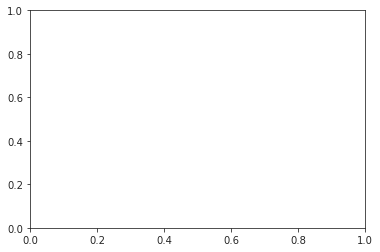

In [17]:
import pylab as plt
import seaborn as sns

from scipy.stats import gaussian_kde
import numpy as np
# from astroML.plotting import hist

from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style("ticks")

axScatter = plt.subplot(111)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)


axScatter.set_xlim(xmin, xmax)
axScatter.set_ylim(ymin, ymax)
# Contourf plot
cfset = axScatter.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = axScatter.contour(xx, yy, f, colors='k')
# Label plot
axScatter.scatter(x, y, marker='o', s=1, alpha=0.2, color='k')
axScatter.set_aspect('auto')

axScatter.set_xlabel(r'$X$')
axScatter.set_ylabel(r'$Y$')



# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(axScatter)

axHistx = divider.append_axes("top", size=1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", size=1.2, pad=0.1, sharey=axScatter)

# the scatter plot:
# histograms
kde = gaussian_kde(x)
X_plot = np.linspace(xmin, xmax, 1000)
X_dens = kde.evaluate(X_plot)
axHistx.fill(X_plot, X_dens, fc='#AAAAFF',alpha=0.2)
hist(x, bins='knuth', ax=axHistx, color='black', histtype='step', normed=True)


kde = gaussian_kde(y)
Y_plot = np.linspace(ymin,ymax, 1000)
Y_dens = kde.evaluate(Y_plot)
axHisty.fill(Y_plot, Y_dens, fc='#AAAAFF' ,alpha=0.2)
hist(y, bins='knuth', ax=axHisty, color='black', histtype='step', normed=True, orientation='horizontal')

color of immune cell

In [42]:
colors = utils.read_color()         # read leukocyte color

cell_label=list(local_DF.columns)[1:]                                       # left cell
color_ls=colors.loc[cell_label].HEX.values   # select from all

## drawing for new 4

In [159]:
iicolumn=3

In [160]:
new4[iicolumn]

'number_pack_years_smoked'

In [161]:
stage=pd.read_csv(
    os.path.join(data_path,'label','patient_stage.csv'),
    index_col=0
    ).loc[:,new4]
stage = stage.replace(' ',np.nan)
print(sum(stage[new4[iicolumn]].isna()))
stage = stage.dropna(axis=0,how='any',subset=[new4[iicolumn]])

1998


In [162]:
merged_df = stage.merge(local_DF,left_index=True,right_on=['id'],how='inner').set_index('id')
print(merged_df.shape)
all_data=merged_df.iloc[:,4:].values

(1151, 24)


In [163]:
# iicolumn = next(iicolumn_gen)
x_label = merged_df.iloc[:,iicolumn].astype(float)
x_media = np.quantile(x_label,0.5)
print(x_media)

40.0


should skip this step if label is categorical

In [165]:
x_label[x_label < x_media]= 0
x_label[x_label >= x_media]= 2

number_pack_years_smoked
this will take several minutes


Text(0.5, 1, 'number_pack_years_smoked')

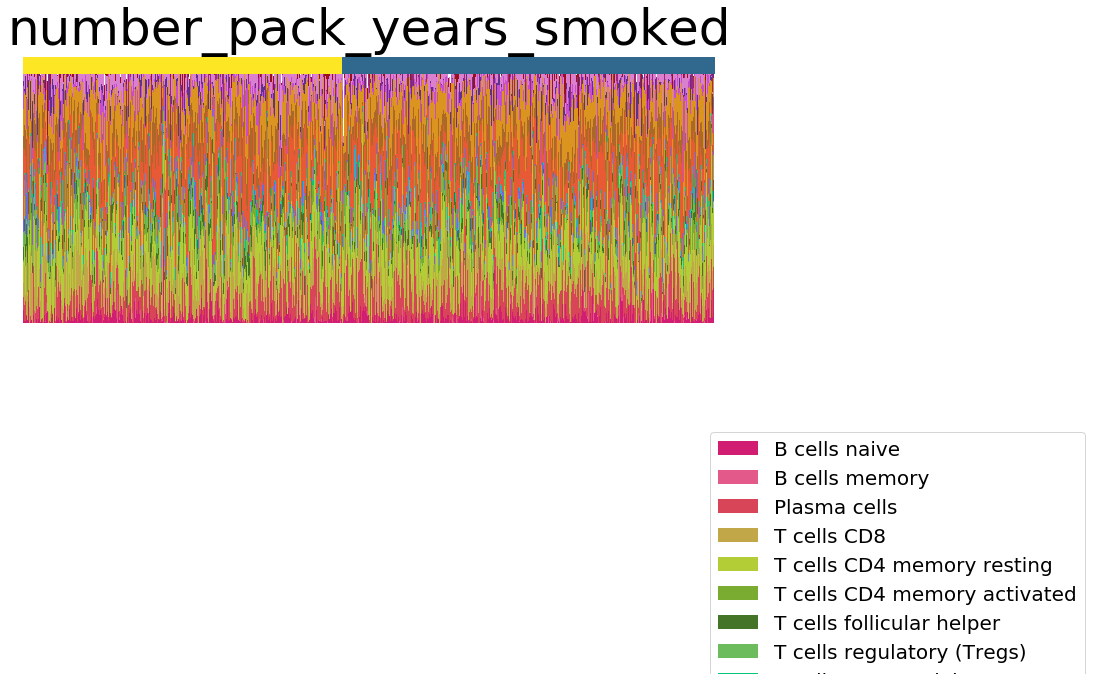

In [166]:
sort_data,label = LEUC.sort_data_by_label(all_data,None,None,direct_label=x_label)
print(merged_df.columns[iicolumn])

stack_barplot(sort_data,label,cmap=color_ls)
plt.title(merged_df.columns[iicolumn],fontsize=50)

# make a label DF

goal : merging cluster label, cancer type and t_sne axis together

In [18]:
cancer_types = list(DF.keys())
for cancer_type in cancer_types:
    # DF is read above
    DF[cancer_type].loc[:,'cancer_type'] = np.array([cancer_type]*DF[cancer_type].shape[0])

In [25]:
DF0=DF[cancer_types[0]]                    # take the first DF as the base
for cancer_type in cancer_types[1:]:
    DF0 = DF0.append(DF[cancer_type])      # concatenate DF by append`

In [28]:
all_tsne = pd.read_csv(os.path.join(tsne_path,'ALL_tsne_p30.csv'))

In [39]:
label_df = pd.read_csv(os.path.join(report_path,'ALL_&_label','cluster_labelALL1.csv'),index_col=0)

save to csv

In [53]:
merged_df=all_tsne.merge(label_df,left_on=['id'],right_on=['id'],how='inner')

merged_df = merged_df.merge(DF0[['id','cancer_type']],left_on=['id'],right_on=['id'],how='inner')

merged_df.to_csv(os.path.join(tsne_path,'ALL_tsne_p30.csv'),index=False)

# summarize the partition of each cancer type in 5 groups

In [55]:
from IPython.display import HTML

In [92]:
tab_cancertype = '         {} '*len(cancer_types)

In [97]:
print('———————————————————'*9)
print(tab_cancertype.format(*cancer_types))
print('———————————————————'*9)
for i in range(1,6):
    print('cluster',i)
print('———————————————————'*9)

———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
         BLADDER          CERVICAL          COLON          HNSCC          LIVER          MELANOMA          STOMACH          KIDNEY          NSCLC          TNBC 
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
cluster 1
cluster 2
cluster 3
cluster 4
cluster 5
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————


In [158]:
clust = ['cluster'+str(i) for i in range(1,6)]
statistics = pd.DataFrame(clust,columns=['km_label']).set_index('km_label')

In [159]:
for cancer_type in cancer_types:
    statistics.loc[:,cancer_type] = [np.sum((merged_df.cancer_type == cancer_type) & (merged_df.km ==i)) for i in range(5)]
count = statistics.values
partition = count / np.sum(count,axis=0)
statistics=statistics.astype(str)  # for the convinent of add proportion info

In [160]:
for cancer_type in cancer_types:
    total_num = np.sum(merged_df.cancer_type == cancer_type)
    
    statistics.loc[:,cancer_type] = statistics.loc[:,cancer_type].apply(
        lambda x: x + '({:.2f} %)'.format(int(x)/total_num *100)
    )

In [184]:
row_sum=pd.DataFrame(
    np.array(['{}({:.2f}%)'.format(i,j) for i,j in zip(count.sum(axis=0),(100*count.sum(axis=0)/count.sum()))]).reshape(1,10),
    columns=statistics.columns
)

In [186]:
statistics=statistics.append(row_sum)

In [192]:
col_count= np.array(list(count.sum(axis=1))+[count.sum()])
col_part = col_count/count.sum()*100

In [193]:
col_sum = ['{} ({:.2f}%)'.format(col_count[i],col_part[i]) for i in range(6)]

In [195]:
statistics.insert(10,'total',value=col_sum)

In [203]:
statistics.index = list(statistics.index)[:5]+['sum']

In [205]:
statistics.to_csv(os.path.join(report_path,'cluster_ratio_statistics.csv'),index=True)